In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [60]:
data = pd.read_csv('aggregated_data.csv')

# INFLATION ADJUSTMENT
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

# ['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'CPI_US', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES']
# data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop(['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES', 'CORN_FUTURES_TYPICAL_PRICE', 'DIESEL_RETAIL_PRICE'], axis=1)
data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop(['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES', 'CORN_FUTURES_TYPICAL_PRICE'], axis=1)
print(data.columns)


Index(['AVG_PRICE_AUCTION', 'FEEDER_CATTLE_FUTURES_TYPICAL_PRICE',
       'US_MXN_RATES', 'CPI_US', 'DIESEL_RETAIL_PRICE',
       'FEDERAL_INTEREST_RATE', 'ALFAFA_HAY_PPI', 'CORN_PPI'],
      dtype='object')


In [61]:
# # CREATE RANDOM FOREST MODEL
X = data.drop(['AVG_PRICE_AUCTION'], axis=1)
y = data['AVG_PRICE_AUCTION']

# # SPLIT DATA INTO 80/20 TRAINING TESTING SETS
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = int(len(data.index) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# print(train_data.to_string())
# plt.plot(train_data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'])

X_train = train_data.drop('AVG_PRICE_AUCTION', axis=1)
y_train = train_data['AVG_PRICE_AUCTION']
X_test = test_data.drop('AVG_PRICE_AUCTION', axis=1)
y_test = test_data['AVG_PRICE_AUCTION']

In [62]:
from sklearn.discriminant_analysis import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length=10):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], 
                self.y[idx+self.sequence_length])
    
def prepare_data(df, target_column, feature_columns, sequence_length=10, train_split=0.8):
    # 1. Normalize the data
    scaler = StandardScaler()
    features = df[feature_columns].values
    features_normalized = scaler.fit_transform(features)
    
    # 2. Convert target to numpy array
    target = df[target_column].values.reshape(-1, 1)
    target_normalized = scaler.fit_transform(target)
    
    # 3. Create sequences
    dataset = TimeSeriesDataset(features_normalized, target_normalized, sequence_length)
    
    # 4. Split into train and test
    train_size = int(len(dataset) * train_split)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    # 5. Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader, scaler

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out
    
# Training loop example
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Calculate loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    return train_losses

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    return predictions, actuals

In [64]:
train_loader, test_loader, scaler = prepare_data(
    data,
    target_column='AVG_PRICE_AUCTION',
    feature_columns=['AVG_PRICE_AUCTION', 'FEEDER_CATTLE_FUTURES_TYPICAL_PRICE', 'US_MXN_RATES', 'CPI_US', 'FEDERAL_INTEREST_RATE'],
    sequence_length=10,
    train_split=0.8
)

In [65]:
model = LSTMModel(input_size=5, hidden_size=64, num_layers=2, output_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = train_model(model, train_loader, criterion, optimizer)

Epoch [10/100], Loss: 0.0442
Epoch [20/100], Loss: 0.0354
Epoch [30/100], Loss: 0.0305
Epoch [40/100], Loss: 0.0301
Epoch [50/100], Loss: 0.0244
Epoch [60/100], Loss: 0.0210
Epoch [70/100], Loss: 0.0201
Epoch [80/100], Loss: 0.0214
Epoch [90/100], Loss: 0.0153
Epoch [100/100], Loss: 0.0130


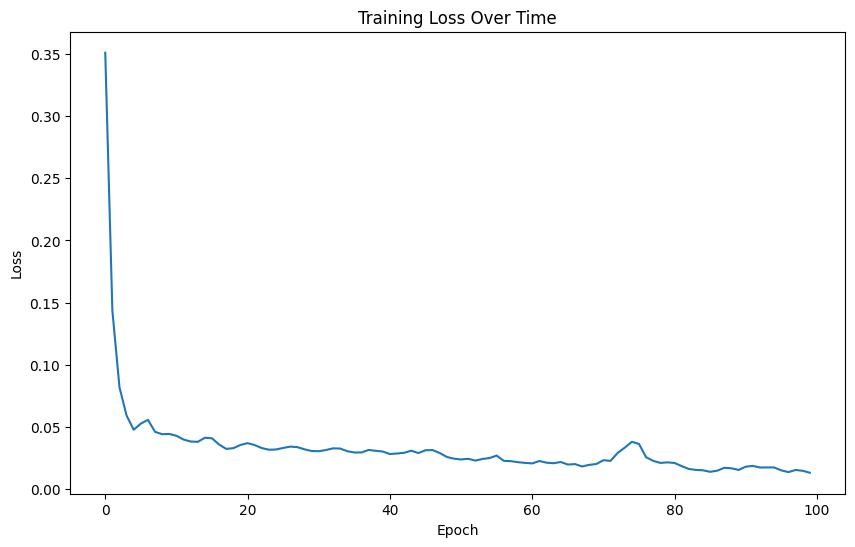

In [66]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [67]:
predictions, actuals = evaluate_model(model, test_loader, criterion)

Test Loss: 0.0328
MSE: 0.0341
MAE: 0.1386
R2 Score: 0.9719


Test Loss: 0.0328
MSE: 0.0341
MAE: 0.1386
R2 Score: 0.9719


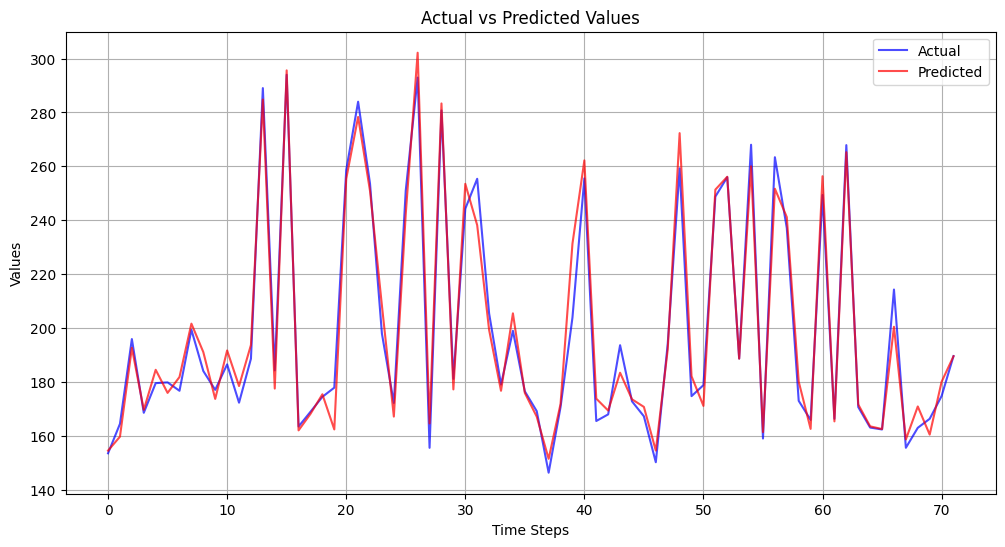

In [70]:
def plot_predictions(predictions, actuals, scaler=None):
    # If data was scaled, inverse transform the predictions and actuals
    if scaler is not None:
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
    
    # Convert to numpy arrays if they aren't already
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    # Create timestamp index for x-axis
    timestamps = np.arange(len(predictions))
    
    # Matplotlib plot
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, actuals, label='Actual', color='blue', alpha=0.7)
    plt.plot(timestamps, predictions, label='Predicted', color='red', alpha=0.7)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotly scatter plot
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=actuals,
        y=predictions,
        mode='markers',
        name='Predictions vs Actuals',
        marker=dict(color='blue', size=8, opacity=0.6)
    ))
    
    # Add diagonal line (perfect predictions)
    min_val = min(min(actuals), min(predictions))
    max_val = max(max(actuals), max(predictions))
    fig.add_trace(go.Scatter(
        x=[min_val, max_val],
        y=[min_val, max_val],
        mode='lines',
        name='Perfect Prediction',
        line=dict(color='red', dash='dash')
    ))
    
    fig.update_layout(
        title='Predicted vs Actual Values (Scatter)',
        xaxis_title='Actual Values',
        yaxis_title='Predicted Values',
        showlegend=True
    )
    
    fig.show()

# Get predictions and actuals from model evaluation
predictions, actuals = evaluate_model(model, test_loader, criterion)

# Create the plots
plot_predictions(predictions, actuals, scaler)